In [16]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import torch
import numpy as np
import os
from net.spherenet import SphereNet
from net.pfe import PFE
from net.resnet import *
from utils import *

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [140]:
import matplotlib.pyplot as plt
plt.imshow(datasets.LFWPeople(root='./data',split='10fold',image_set='original')[0][0])

RuntimeError: Dataset not found or corrupted. You can use download=True to download it

In [18]:
def mls_distance(x1, x2):
    mu1, sigma_sq1 = [np.array(i.cpu()) for i in x1]
    mu2, sigma_sq2 = [np.array(i.cpu()) for i in x2]
    sigma_sq_mutual = sigma_sq1 + sigma_sq2   # must be positive for np.log to work
    dist = np.sum(np.square(mu1 - mu2) / sigma_sq_mutual + np.log(sigma_sq_mutual), axis=1)
    return -dist

In [20]:
def similarity_score(x1, x2, metric):
    func = {
        'cosine' : cosine_similarity,   # embedding
        'euclidean' : euclidean_distances, # mu
        'mls' : mls_distance   # mu, log_sigma
    }
    
    if metric!='mls':
        if type(x1) is tuple:
            x1 = x1[0].cpu()
        if type(x2) is tuple:
            x2 = x2[0].cpu()
    return func[metric](x1, x2)

In [21]:
def evaluate_pair(model, dataset, metric='cosine', threshold=None):
    model.to(device)
    model.eval()
    with torch.no_grad():
        sim_scores = []
        labels = []
        img1s = []
        img2s = []
        for img1, img2, label in dataset:
            img1s.append(img1.to(device).unsqueeze(dim=0))
            img2s.append(img2.to(device).unsqueeze(dim=0))
            labels.append(label)
        img1s = torch.cat(img1s, dim=0)
        img2s = torch.cat(img2s, dim=0)
        x1 = model(img1s.to(device))
        x2 = model(img2s.to(device))
        sim_score = similarity_score(x1,x2,metric)
        sim_scores.append(sim_score)
    sim_scores = np.array(sim_scores)
    labels = np.array(labels)
    
    # choose threshold with most accuracies
    label_vec = (sim_scores>0.5) == labels
    if threshold != None:
        label_vec = (sim_scores>threshold) == labels
        far, tar, thresholds = roc_curve(np.repeat(labels, sim_score.shape[0]), sim_score.reshape(-1))
        # Calculate AUC using scikit-learn
        auc_score = auc(far, tar)
        return far, tar, auc_score
    
#     score_pos = sim_scores[label_vec==True]
#     thresholds = np.sort(score_pos)
    thresholds = np.array([i/4 for i in range(21)])
    accuracies = np.zeros(np.size(thresholds))
    for i, threshold in enumerate(thresholds):
        pred_vec = sim_scores>=threshold
        accuracies[i] = np.mean(pred_vec==labels)

    argmax = np.argmax(accuracies)
    accuracy = accuracies[argmax]
    threshold = np.mean(thresholds[accuracies==accuracy])
    return accuracy, threshold

In [22]:
def compose(size):
    compose = transforms.Compose([
        transforms.Resize((size,size)),
        transforms.Grayscale(num_output_channels=3),  # Convert to Grayscale RGB
        transforms.ToTensor(),
    ])
    return compose

In [23]:
train_dataset = datasets.LFWPairs(root='./data',split='train',download=True, transform=compose(100))
train_loader = DataLoader(dataset=train_dataset,batch_size=128)
test_dataset = datasets.LFWPairs(root='./data',split='test',download=True, transform=compose(100))
test_loader = DataLoader(dataset=test_dataset,batch_size=128,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
model = torch.load('./saved_models/resnet50_lfw_pfe.ptm')
threshold = 0.5
# accuracy, threshold=evaluate_pair(model, test_dataset, metric='cosine')
# TODO: Fix pfe

In [27]:
import matplotlib.pyplot as plt
def plot_roc(model, dataset, threshold=None, metric='cosine'):
#     far, tar, thresholds = roc_curve(np.repeat(labels, sim_score.shape[0]), sim_score.reshape(-1))
#     auc_score = auc(far, tar)
    if threshold == None:
        accuracy, threshold = evaluate_pair(model, test_dataset, metric='cosine', threshold=threshold)
    far, tar, auc_score = evaluate_pair(model, test_dataset, metric='cosine', threshold=threshold)
    plt.plot(far, tar, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

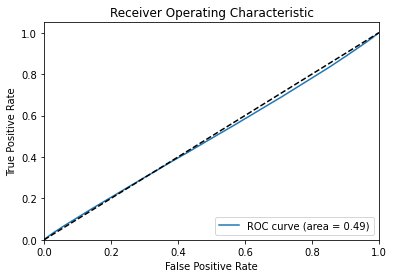

In [28]:
plot_roc(model,test_dataset)

In [19]:
def tar_at_far(tar, far, far_target):
    nearest_far_target=min(far, key=lambda x:abs(x-far_target))
    index=np.where(far==nearest_far_target)
    tar_target=tar[index]
    return tar_target